In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from MetropolisHastings import MetropolisHastingsSampler
from FEM_Solver import  RootFinder2,RootFinder2,FEMSolver
from utilities import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from GaLa import llaplace
from NN import DNN

np.random.seed(42)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tiaming Experiment 3

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## Computing Roots

The first 7 roots are: [1.5707963267941523, 2.153747972623023, 4.000000000000363, 4.577859456206715, 4.712388980384275, 7.287194334850938, 7.853981633975673]


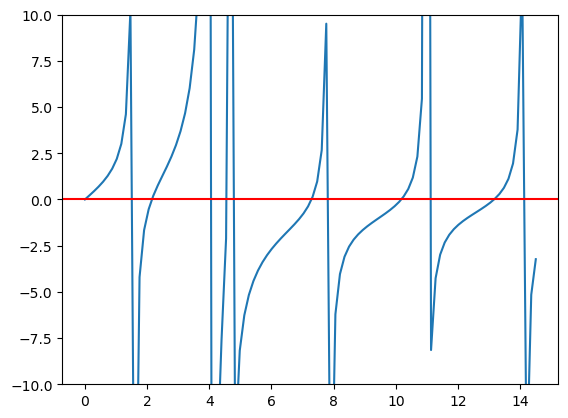

In [2]:
def tang_eq(x):
    return np.tan(x) - 8*(x/(x**2 - 16))

intervals = [(1,2),(2,3),(3.8,4.1),(4.1,4.6),(4.7,4.8),(7.2,7.3),(7.3,8),(10,10.2),(10.2,11.5),(13,13.2),(14,14.5)]
n = 7

root_finder = RootFinder2(n, tang_eq, intervals)
roots = root_finder.find_roots()
root_finder.plot_equation()

print(f"The first {n} roots are: {roots}")

theta_t = np.array([0.09762701, 0.43037873, 0.20552675, 0.08976637, -0.1526904, 0.29178823, -0.12482558, 0.783546, 0.92732552, -0.23311696])

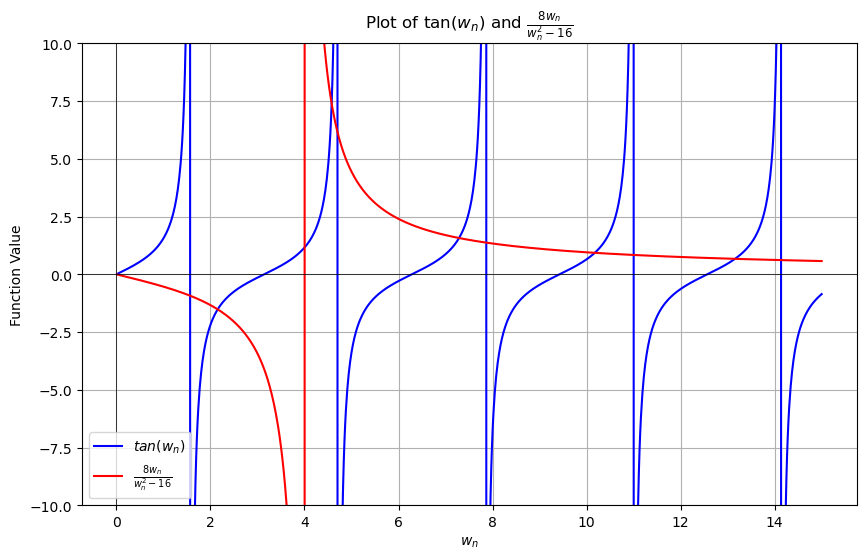

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def tan_func(wn):
    return np.tan(wn)

def rational_func(wn):
    return (8 * wn) / (wn**2 - 16)

# Create a range of values for wn avoiding the singularities of tan(wn)
wn_values = np.linspace(0, 15, 1000)

# To avoid the singularities at multiples of pi/2, let's exclude those values
wn_values = wn_values[(wn_values % (np.pi/2)) != 0]

# Evaluate the functions
tan_values = tan_func(wn_values)
rational_values = rational_func(wn_values)

# Plot the functions
plt.figure(figsize=(10, 6))
plt.plot(wn_values, tan_values, label=r'$tan(w_n)$', color='blue')
plt.plot(wn_values, rational_values, label=r'$\frac{8w_n}{w_n^2 - 16}$', color='red')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

# Add labels and title
plt.title(r'Plot of $\tan(w_n)$ and $\frac{8w_n}{w_n^2 - 16}$')
plt.xlabel(r'$w_n$')
plt.ylabel('Function Value')
plt.legend()
plt.ylim(-10, 10)  # Limit the y-axis to focus on intersections
plt.grid(True)
plt.show()


In [4]:
# Example Usage
lam = 1 / 4
M = 7

finder = RootFinder(lam, M)
roots = finder.find_roots()

print("Roots:", roots)

Roots: [ 2.15374797  4.57785946  7.28719433 10.17397019 13.15666747 16.19232721
 19.25912069]


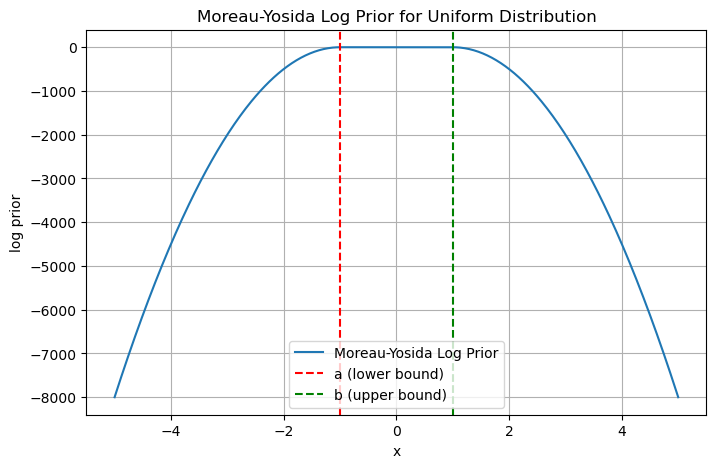

In [5]:

# Define the Moreau-Yosida log prior function
def log_prior_moreau_yosida(x, a, b, lam):
    log_prior = np.zeros_like(x)
    log_prior[x < a] = -(1 / (2 * lam)) * (x[x < a] - a)**2
    log_prior[x > b] = -(1 / (2 * lam)) * (x[x > b] - b)**2
    return log_prior

def log_uniform_moreau_yosida(x, lam):
    # Apply the Moreau-Yosida regularization term to the uniform distribution
    # Assuming x is the input parameter, and lam is the regularization parameter
    regularization_term =-(np.maximum(np.abs(x)-1, 0) ** 2) / (2 * lam)
    scaling_term = (2 + np.sqrt(2 * np.pi * lam)) ** (-1)
    
    return regularization_term +  np.log(scaling_term)

# Parameters for the uniform distribution
a = -1.0  # Lower bound
b = 1.0  # Upper bound
lam = 1e-3  # Regularization parameter (lambda)

# Generate a range of x values
x_vals = np.linspace(-5, 5, 500)

# Compute the log prior values
log_prior_vals = log_uniform_moreau_yosida(x_vals, lam)

# Plot the log prior
plt.figure(figsize=(8, 5))
plt.plot(x_vals, log_prior_vals, label='Moreau-Yosida Log Prior')
plt.axvline(a, color='r', linestyle='--', label='a (lower bound)')
plt.axvline(b, color='g', linestyle='--', label='b (upper bound)')
plt.xlabel('x')
plt.ylabel('log prior')
plt.title('Moreau-Yosida Log Prior for Uniform Distribution')
plt.legend()
plt.grid(True)
plt.show()


# Generating Artificial Data for Inverse Problem

In [6]:
theta_th=np.array([0.098, 0.430])
var = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]
obs = [10,25,50,100]
vertices = [50]

# for ob in obs:
#     for vr in var:
#         st = np.sqrt(vr)
#         obs_points, obs_sol = generate_noisy_obs(ob, theta_t=theta_th, mean=0, std=st,vert=200)

#         for hvert in vertices:

#             sampler = MetropolisHastingsSampler(obs_points, obs_sol, sig = st,numerical = True, roots=roots, vert=hvert)

#             samp_num,dt_tracker_num = sampler.run_sampler(n_chains=1005000)

#             np.save(f'./Models/FEM_h{hvert}_var{vr}_obs{ob}.npy', samp_num)

In [7]:
# fig, axs = plt.subplots(len(var), len(obs), figsize=(18, 18),sharex=True)
# fig.suptitle(fr"Posterior Distributions $\theta_{1}$", color="blue", fontsize=16)
# plt.subplots_adjust(hspace=0.25)

# # Plotting for parameter 1
# for i,vr in enumerate(var):
#     for j,ob in enumerate(obs):
#         for hvert in vertices:
#             sample = np.load(f'./Models/FEM_h{hvert}_var{vr}_obs{ob}.npy')
#             axs[i,j].hist(sample[:, 0], bins=30, density=True, alpha=0.6, histtype='step',
#                     label=f"FEM({hvert})", linestyle="--", linewidth=0.75)
            
#         axs[-1,j].set_xlabel(r"$\theta_{1}$")
#         axs[i,j].set_xlim((-1,1))
#         if j==0 and i == 0:
#             axs[i,j].set_title(fr"$N_{{y}} = {ob}$, $\sigma^{2} = {vr}$")
#         elif  j==0:
#             axs[i,j].set_title(fr"$\sigma^{2} = {vr}$")
#         else:
#             axs[0,j].set_title(fr"$N_{{y}} = {ob}$")

# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(vertices), frameon=False, fontsize=10)
# plt.tight_layout(rect=[0, 0, 0, -10])
# plt.savefig("Posterior_distribution_theta1_own.pdf")


In [8]:
# fig, axs = plt.subplots(len(var), len(obs), figsize=(18, 18),sharex=True)
# fig.suptitle(fr"Posterior Distributions $\theta_{2}$", color="blue", fontsize=16)
# plt.subplots_adjust(hspace=0.25)

# # Plotting for parameter 1
# for i,vr in enumerate(var):
#     for j,ob in enumerate(obs):
#         for hvert in vertices:
#             sample = np.load(f'./Models/FEM_h{hvert}_var{vr}_obs{ob}.npy')
#             axs[i,j].hist(sample[:, 1], bins=30, density=True, alpha=0.6, histtype='step',
#                     label=f"FEM({hvert})", linestyle="--", linewidth=0.75)
            
#         axs[-1,j].set_xlabel(r"$\theta_{2}$")
#         axs[i,j].set_xlim((-1,1))
#         if j==0 and i == 0:
#             axs[i,j].set_title(fr"$N_{{y}} = {ob}$, $\sigma^{2} = {vr}$")
#         elif  j==0:
#             axs[i,j].set_title(fr"$\sigma^{2} = {vr}$")
#         else:
#             axs[0,j].set_title(fr"$N_{{y}} = {ob}$")

# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(vertices), frameon=False, fontsize=10)
# plt.tight_layout(rect=[0, 0, 0, -10])
# plt.savefig("Posterior_distribution_theta2_own.pdf")


# No noise 

In [9]:
# obs = 10
# theta_th=np.array([0.098, 0.430])

# mean, var = 0,[1e-5,1e-3,1e-2,1e-1,1,10,100]
# #vertices = [10,250,500,1000,2000]
# vertices = [10,500,2000]

# for vr in var:
#     st = np.sqrt(vr)
#     obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=mean, std=0,vert=5000)

#     for hvert in vertices:

#         sampler = MetropolisHastingsSampler(obs_points, obs_sol, sig = st,numerical = True, roots=roots, vert=hvert)

#         samp_num,dt_tracker_num = sampler.run_sampler(n_chains=50000)

#         np.save(f'./Models/FEM_post2_h{hvert}_var{vr}.npy', samp_num)

In [10]:
# for vr in var:
#     samples = dict()
#     for hvert in vertices:
#         samples[hvert] = np.load(f'./Models/FEM_post2_h{hvert}_var{vr}.npy')

#     plot_posterior_distributions(samples, vertices,sufix="Var:" + str(vr), labelsuf="FEM")

# Pyro

In [11]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver


# # Define the model using a coarse FEM solver
# def model(surrogate_fem_solver,synthetic_data, points,noise_std,vert):
#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points))

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data))

#     return y


# for ob in obs:
#     for vr in var:
#         st = np.sqrt(vr)

#         obs_points, obs_sol = generate_noisy_obs(ob, theta_t=theta_th, mean=0, std=st,vert=200)

#         # Define the MCMC kernel (using Random Walk Metropolis)
#         kernel = mcmc.RandomWalkKernel(model, target_accept_prob=0.234)

#         # Create an MCMC object with the kernel
#         mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#         for hvert in vertices:
#             surrogate_fem_solver = FEMSolver(theta=np.zeros(theta_th.shape[0]), k_roots=roots, vert=hvert)

#             # Run the MCMC inference
#             mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st,hvert)

#             # Get the results (posterior samples)
#             samples = mcmc_sampler.get_samples()
#             samples = samples["theta"].numpy()

#             np.save(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{ob}.npy', samples)


In [12]:
# fig, axs = plt.subplots(len([1e-5,1e-4,1e-3]),2 , figsize=(10, 5),sharex=True)
# #fig.suptitle(fr"Posterior Distributions$", color="blue", fontsize=12)
# plt.subplots_adjust(hspace=0.25)
# xbins = np.arange(-1, 1.1, 0.02)

# # Plotting for parameter 1
# for i,vr in enumerate([1e-5,1e-4,1e-3]):
#         sample = np.load(f'./Models/FEM_h50_var{vr}_obs10.npy')
#         axs[i,0].hist(sample[:, 0], bins=xbins, density=True, alpha=0.6, histtype='step',
#                 label=f"CHR({hvert})", linestyle="--", linewidth=0.75,color = "red")
        
#         axs[i,1].hist(sample[:, 1], bins=xbins, density=True, alpha=0.6, histtype='step',
#                 label=f"CHR({hvert})", linestyle="--", linewidth=0.75,color = "red")
        
        
#         sample = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs10.npy')
#         axs[i,0].hist(sample[:, 0], bins=xbins, density=True, alpha=0.6, histtype='step',
#                 label=f"Pyro({hvert})", linestyle="--", linewidth=0.75,color = "black")
        
#         axs[i,1].hist(sample[:, 1], bins=xbins, density=True, alpha=0.6, histtype='step',
#                 label=f"Pyro({hvert})", linestyle="--", linewidth=0.75,color = "black")
        

#         axs[-1,0].set_xlabel(r"$\theta_{1}$"),axs[-1,1].set_xlabel(r"$\theta_{2}$")
#         axs[-1,0].set_xlim((-1,1))
        
#         axs[i,0].set_title(fr"$\sigma^{2} = {vr}$")
       

# handles, labels = axs[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=2, frameon=False, fontsize=10)
# #plt.tight_layout(rect=[0, 0, 0, -10])
# plt.savefig("Posterior_distribution_theta1_pyro.pdf")

In [13]:
import torch
import torch.distributions as dist
from pyro.distributions import Distribution

class MoreauYosidaPrior(Distribution):
    def __init__(self, lam, batch_shape=torch.Size([]), device='cpu'):
        super().__init__()
        self.device = device
        self.batch_shape = torch.Size(batch_shape)  # Ensure batch_shape is a torch.Size object
        self.lam = torch.tensor(lam, dtype=torch.float32, device=self.device)


    @property
    def event_shape(self):
        """The event shape for this distribution is 1-dimensional."""
        return torch.Size([1])

    @property
    def support(self):
        """The support of the distribution is the whole real line."""
        return dist.constraints.real

    def log_prob(self, x):
        """Calculate the log probability of x under the Moreau-Yosida prior."""
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, device=self.device)

        # Calculate the regularization term
        regularization_term = -(torch.clamp(torch.abs(x) - 1, min=0) ** 2) / (2 * self.lam)
        log_prob = regularization_term - torch.log(2 + torch.sqrt(2 * torch.pi * self.lam))

        return log_prob

    def sample(self, sample_shape=torch.Size()):
        """Sample from the Moreau-Yosida prior using importance sampling."""
        sample_shape = torch.Size(sample_shape)  # Ensure sample_shape is a torch.Size object
        total_shape = self.batch_shape + sample_shape  # Concatenate batch_shape with sample_shape

        # Proposal distribution with heavier tails (e.g., Normal distribution)
        proposal_dist = dist.Normal(loc=0.0, scale=2.0)  # Wider scale for more tail coverage
        proposals = proposal_dist.sample(total_shape).to(self.device)

        # Calculate log probabilities for the proposals under the Moreau-Yosida prior
        log_prob_samples = self.log_prob(proposals)

        # Calculate log probability of the proposal distribution
        log_prob_proposal = proposal_dist.log_prob(proposals)

        # Calculate weights for importance sampling
        weights = torch.exp(log_prob_samples - log_prob_proposal)

        # Clamp weights to avoid negative entries
        weights = torch.clamp(weights, min=0)

        # Normalize weights
        weights_sum = torch.sum(weights)
        if weights_sum > 0:  # Prevent division by zero
            weights /= weights_sum
        else:
            # If all weights are zero, return uniformly sampled values
            return proposals

        # Resample according to weights (multinomial resampling)
        idx = torch.multinomial(weights, total_shape[0], replacement=True)
        resampled_proposals = proposals[idx]

        return resampled_proposals

    def expand(self, batch_shape, _instance=None):
        """Expand the distribution to a new batch shape."""
        return MoreauYosidaPrior(self.lam, batch_shape, self.device)

# Example usage
lam = 0.001
my_prior = MoreauYosidaPrior(lam)

# Draw samples
num_samples = 10000
samples = my_prior.sample((num_samples,))
# Output some samples
print(f"Samples: {samples[:5]}")


Samples: tensor([ 0.1985, -0.0998,  0.7925, -0.2008, -0.8312])


(-3.0, 3.0)

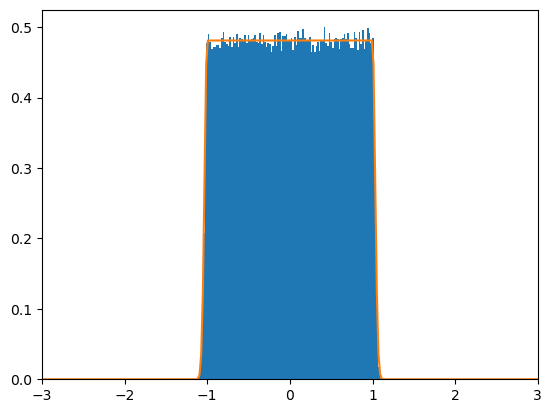

In [14]:

lam = 0.001
my_prior = MoreauYosidaPrior(lam)

# Draw samples
num_samples = 1000000
samples = pyro.sample("theta", my_prior.expand([num_samples]))

def log_uniform_moreau_yosida(x, lam):
    # Apply the Moreau-Yosida regularization term to the uniform distribution
    # Assuming x is the input parameter, and lam is the regularization parameter
    regularization_term =-(np.maximum(np.abs(x)-1, 0) ** 2) / (2 * lam)
    scaling_term = (2 + np.sqrt(2 * np.pi * lam)) ** (-1)
    
    return regularization_term +  np.log(scaling_term)

# Generate a range of x values
x_vals = np.linspace(-5, 5, 500)

plt.hist(samples,density=True, bins=x_vals)
plt.plot(x_vals,np.exp(log_uniform_moreau_yosida(x_vals,lam)))
plt.xlim(-3,3)

In [ ]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver


# Define the model using a coarse FEM solver
def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):

    lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
    moreau_prior = MoreauYosidaPrior(lam,device=device)

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", moreau_prior.expand([2]))

    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().cpu().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

theta_th=np.array([0.098, 0.430])

for vr in [1e-4,5e-4,1e-3,5e-3]:
    st = np.sqrt(vr)

    obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

    # Define the MCMC kernel (using Random Walk Metropolis)
    kernel = mcmc.RandomWalkKernel(model, target_accept_prob=0.234)

    # Create an MCMC object with the kernel
    mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    surrogate_fem_solver = FEMSolver(theta=np.zeros(theta_th.shape[0]), vert=50)

    # Run the MCMC inference
    mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

    # Get the results (posterior samples)
    samples = mcmc_sampler.get_samples()
    samples = samples["theta"].numpy()

    np.save(f'./Models/FEM_pyro_h{50}_var{vr}_obs{10}.npy', samples)

Sample:  68%|██████▊   | 680186/1005000 [31:36, 370.91it/s, step size=5.03e-02, acc. prob=0.222]

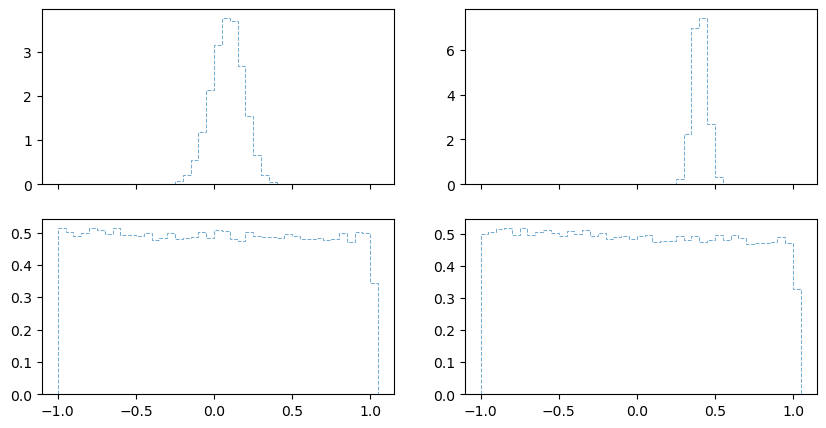

In [170]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5),sharex=True)
xbins = np.arange(-1, 1.1, 0.05)
for i,vr in  enumerate([1e-4,5e-4,1e-3,5e-3]):
    sample = np.load(f'./Models/FEM_pyro_h{50}_var{vr}_obs{10}.npy')
    axs[i,0].hist(sample[:, 0], bins=xbins, density=True, alpha=0.6, histtype='step',
                        linestyle="--", linewidth=0.75)
    axs[i,1].hist(sample[:, 1], bins=xbins, density=True, alpha=0.6, histtype='step',
                        linestyle="--", linewidth=0.75)

In [ ]:
# fig, axs = plt.subplots(len(var), len(obs), figsize=(18, 18),sharex=True)
# fig.suptitle(fr"Posterior Distributions Pyro $\theta_{1}$", color="blue", fontsize=16)
# plt.subplots_adjust(hspace=0.25)
# xbins = np.arange(-1, 1.1, 0.05)

# # Plotting for parameter 1
# for i,vr in enumerate(var):
#     for j,ob in enumerate(obs):
#         for hvert in vertices:
#             sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{ob}.npy')
#             axs[i,j].hist(sample[:, 0], bins=xbins, density=True, alpha=0.6, histtype='step',
#                     label=f"FEM({hvert})", linestyle="--", linewidth=0.75)
            
#         axs[-1,j].set_xlabel(r"$\theta_{1}$")
#         axs[i,j].set_xlim((-1,1))
#         if j==0 and i == 0:
#             axs[i,j].set_title(fr"$N_{{y}} = {ob}$, $\sigma^{2} = {vr}$")
#         elif  j==0:
#             axs[i,j].set_title(fr"$\sigma^{2} = {vr}$")
#         else:
#             axs[0,j].set_title(fr"$N_{{y}} = {ob}$")

# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(vertices), frameon=False, fontsize=10)
# plt.tight_layout(rect=[0, 0, 0, -10])
# plt.savefig("Posterior_distribution_theta1_pyro.pdf")


In [ ]:
# fig, axs = plt.subplots(len(var), len(obs), figsize=(18, 18),sharex=True)
# fig.suptitle(fr"Posterior Distributions Pyro $\theta_{2}$", color="blue", fontsize=16)
# plt.subplots_adjust(hspace=0.25)

# # Plotting for parameter 1
# for i,vr in enumerate(var):
#     for j,ob in enumerate(obs):
#         for hvert in vertices:
#             sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{ob}.npy')
#             axs[i,j].hist(sample[:, 1], bins=xbins, density=True, alpha=0.6, histtype='step',
#                     label=f"FEM({hvert})", linestyle="--", linewidth=0.75)
            
#         axs[-1,j].set_xlabel(r"$\theta_{2}$")
#         axs[i,j].set_xlim((-1,1))
#         if j==0 and i == 0:
#             axs[i,j].set_title(fr"$N_{{y}} = {ob}$, $\sigma^{2} = {vr}$")
#         elif  j==0:
#             axs[i,j].set_title(fr"$\sigma^{2} = {vr}$")
#         else:
#             axs[0,j].set_title(fr"$N_{{y}} = {ob}$")

# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(vertices), frameon=False, fontsize=10)
# plt.tight_layout(rect=[0, 0, 0, -10])
# plt.savefig("Posterior_distribution_theta2_pyro.pdf")


### Mini Experiment Inverse Problem

$$
y = \theta_{1} + \theta_{2} + \epsilon
$$

In [64]:
# import numpy as np
# from scipy.stats import uniform

# class MetropolisHastingsSampler:
#     """
#     A class to perform Metropolis-Hastings sampling for parameter inference on the model y = theta1 + theta2 + noise.
#     """

#     def __init__(self, y, nparam=2, sig=1.0, dt_init=1):
#         """
#         Initialize the Metropolis-Hastings sampler.
        
#         Args:
#             x: Input data (independent variables).
#             y: Observed data (dependent variables).
#             sig: Standard deviation of the noise in the observations (default 1.0).
#             dt_init: Initial step size for the proposal distribution (default 0.5).
#         """
#         self.y = y
#         self.sig = sig
#         self.dt = dt_init
#         self.nparam = nparam
#         self.rng = np.random.default_rng() 

#     def log_prior_alpha(self,theta):
#         if np.all((theta >= -1) & (theta <= 1)):
#             return 0  # log(1) = 0 for uniform prior
#         else:
#             return -np.inf  # Outside the prior bounds

#     # def log_prior_alpha(self, pr):
#     #     """
#     #     Evaluates the log prior probability density for the parameters `pr`.
#     #     Assuming a uniform prior distribution over the range [-1, 1].
#     #     """
#     #     # if np.any(pr < -1) or np.any(pr > 1):
#     #     #     return -np.inf  # Immediately reject if parameters are outside bounds
#     #     return np.sum(uniform(loc=-1, scale=2).logpdf(pr))
    
#     def proposals(self, alpha):
#         """
#         Generates proposals for the next step in the Metropolis-Hastings algorithm.
        
#         Args:
#             alpha: Current parameter values.
        
#         Returns:
#             New proposed parameter values based on a normal distribution.
#         """
#         return self.rng.normal(alpha, self.dt, size=alpha.shape)

#     def log_likelihood(self, pr):
#         """
#         Evaluates the log-likelihood for the model y = theta1 + theta2 + noise.
        
#         Args:
#             pr: Current parameters.
        
#         Returns:
#             Log-likelihood value.
#         """
#         theta1, theta2 = pr
#         y_pred = theta1 + theta2  # Model: y = theta1 + theta2
#         return -0.5*np.sum(((self.y - y_pred) ** 2) / (self.sig ** 2))

#     def log_posterior(self, pr):
#         """
#         Evaluates the log-posterior using the model y = theta1 + theta2 + noise.
        
#         Args:
#             pr: Current parameters.
        
#         Returns:
#             Log-posterior value.
#         """
#         return self.log_likelihood(pr) + self.log_prior_alpha(pr)

#     def run_sampler(self, n_chains, verbose=True):
#         """
#         Run the Metropolis-Hastings sampling process.
        
#         Args:
#             n_chains: Number of MCMC chains (iterations) to run.
#             verbose: Whether to print progress and acceptance rate during sampling (default True).
        
#         Returns:
#             alpha_samp: Sampled parameter values.
#             dt_tracker: Step size progression over the chains.
#         """
#         # Initialize parameters
#         alpha = self.rng.uniform(-1, 1, size=self.nparam)  # Start with random parameters
#         alpha_samp = np.zeros((n_chains, alpha.shape[0]))
#         dt_tracker = np.zeros((n_chains, 1))
#         acceptance_rate = 0

#         for i in range(n_chains):
#             # Compute the current log-posterior
#             log_posterior_current = self.log_posterior(alpha)

#             # Propose new alpha values
#             alpha_proposal = self.proposals(alpha)
#             log_posterior_proposal = self.log_posterior(alpha_proposal)

#             # Compute the acceptance ratio
#             a = min(1,np.exp(log_posterior_proposal - log_posterior_current))

#             # Accept or reject the proposal
#             if self.rng.uniform(0,1) < a:
#                 alpha = alpha_proposal
#                 acceptance_rate += 1

#             # Adaptive step size adjustment
#             self.dt = self.dt + self.dt * (a - 0.234) / (i + 1)
#             dt_tracker[i] = self.dt

#             # Store the accepted sample
#             alpha_samp[i, :] = alpha

#             # Print progress every 10% of the iterations
#             if verbose and i % (n_chains // 10) == 0:
#                 print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / (i + 1):.3f}, Step Size: {self.dt:.4f}")

#         if verbose:
#             print(f"Final Acceptance Rate: {acceptance_rate / n_chains:.3f}")

#         return alpha_samp, dt_tracker

In [ ]:
# # Generate y = theta_1 + theta_2 + noise
# n_data = 10
# # True values for theta_1 and theta_2
# theta_true = np.array([0.098, -0.430])

# samples = dict()
# var = [1e-5,1e-2,1e-1,1,10,100,1000,2000]

# for vr in var:
#     st = np.sqrt(vr)

#     noise = np.random.normal(0, st, size=n_data)
#     y = theta_true[0] + theta_true[1] + noise

#     # Initialize and run the sampler
#     sampler = MetropolisHastingsSampler(y, sig = st)
#     alpha_samp, dt_tracker = sampler.run_sampler(n_chains=100000)
#     samples[vr] = alpha_samp

In [ ]:
# for vr in var:
#     fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#     fig.suptitle(f"Posterior Distribution: Var {vr}")

#     alpha_samp = samples[vr]
#     axs[0].hist(alpha_samp[:, 0],bins=30,density=True)
#     axs[1].hist(alpha_samp[:, 1],bins=30,density=True)
#     #sns.kdeplot(alpha_samp[:, 0],  bw_adjust=2, ax=axs[0],clip=(-1,1))
#     #sns.kdeplot(alpha_samp[:, 0],  bw_adjust=2, ax=axs[1],clip=(-1,1))

#     plt.show()